# Hi, This is Frank's notebook 

In [50]:
import numpy as np
from matplotlib import pyplot as plt

import datetime

import pandas as pd

## Let's do some data cleaning and ploting

In [127]:
file = '../sunspot_data/NOAA_daily_1945.txt'

data = pd.read_table(file, header=1, delim_whitespace=True)
data

,Year,Month,Day,SSN
0,1945,1,1,10.0
1,1945,1,2,0.0
2,1945,1,3,1.0
3,1945,1,4,2.0
4,1945,1,5,11.0
...,...,...,...,...
26658,2017,12,27,NaN
26659,2017,12,28,NaN
26660,2017,12,29,NaN
26661,2017,12,30,NaN


In [128]:
fmt = '%Y.%m.%d'

times = []

for index, row in data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row['Year'],row['Month'],row['Day'])
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)


In [129]:
t = Time(times,)

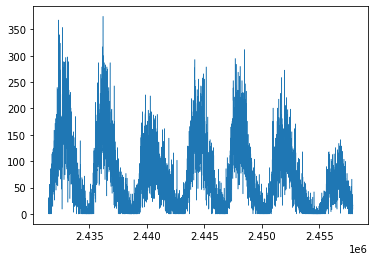

In [130]:
plt.plot(t.jd, data['SSN'], lw=0.5)

In [131]:
stacked = np.vstack((t.jd,data['SSN']))

np.savetxt('NOAA_daily_inJD.txt',stacked.T, fmt='%1.1f',header='Change date format to JD\n Julian_date SSN')

## SILSO data

In [132]:
file = '../sunspot_data/SILSO_daily_1818.csv'

silso_data = pd.read_table(file, sep=';', header=None)
silso_data

,0,1,2,3,4,5,6,7
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
73865,2020,3,27,2020.236,0,0.0,43,0
73866,2020,3,28,2020.239,0,0.0,39,0
73867,2020,3,29,2020.242,0,0.0,36,0
73868,2020,3,30,2020.245,4,0.2,9,0


In [133]:
fmt = '%Y.%m.%d'

times = []

for index, row in silso_data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row[0],row[1],row[2])
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)


In [134]:
t = Time(times,)

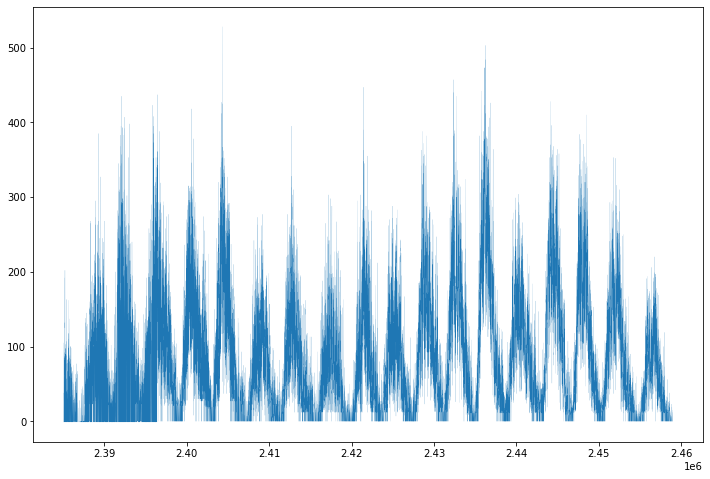

In [135]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(t.jd, silso_data[4], lw=0.1)

In [137]:
silso_stacked = np.hstack((t.jd[:, np.newaxis], silso_data.iloc[:,4:]))

header =  'Change date format to JD\n'
header += 'Julian_date SSN SSN_std observations Definitive_indicator'

np.savetxt('SILSO_daily_inJD.txt',silso_stacked, fmt='%1.1f', header=header)

## SILSO Monthly data

In [157]:
file = '../sunspot_data/SN_m_tot_V2.0.csv'

data = pd.read_table(file, sep=';', header=None)
data

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3251,2019,12,2019.958,1.5,0.5,855,1
3252,2020,1,2020.042,6.4,0.7,722,0
3253,2020,2,2020.124,0.4,0.1,853,0
3254,2020,3,2020.206,1.5,0.2,937,0


In [164]:
fmt = '%Y.%m.%d'

times = []

for index, row in data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row[0],row[1],15)
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)
t = Time(times)

silso_monthly = np.hstack((t.jd[:, np.newaxis], data.iloc[:,2:]))

header =  'Change date format to JD\n'
header += 'Julian_date SSN SSN_std observations Definitive_indicator'

np.savetxt('SILSO_monthly_inJD.txt',silso_monthly, fmt='%1.1f', header=header)

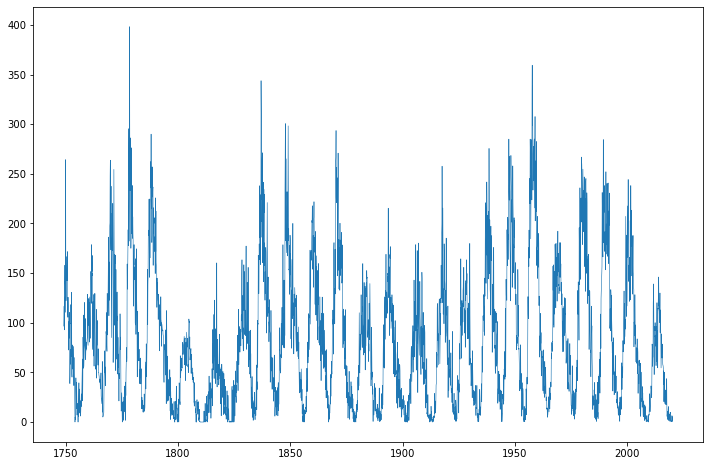

In [181]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(data[2], data[3], lw=0.6)

## Let's try some Gaussian Processes regression

In [138]:
import george
from george import kernels
from george.modeling import Model

/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [169]:
silso_monthly = np.loadtxt('SILSO_monthly_inJD.txt')

silso_monthly = silso_monthly[silso_monthly[:,3] != -1]
silso_monthly.shape

(2428, 6)

In [144]:
k1 = 66**2 * kernels.ExpSquaredKernel(metric=67**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(gamma=2/1.3**2, log_period=0.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2)
kernel = k1 + k2 + k3 + k4

In [461]:
k1 = np.exp(5.9) * kernels.ExpSquaredKernel(metric=np.exp(1.7))
k2 = np.exp(8.3) * kernels.ExpSine2Kernel(gamma=13,log_period=2.4)* kernels.ExpSquaredKernel(metric=np.exp(1))
# k3 = np.exp(5.5) * kernels.ExpSquaredKernel(metric=np.exp(-10))
# k4 = np.exp(1) * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)

kernel =  k1 + k2 #+ k3 + k4

In [474]:
# select only nth data points
nth = 15
data_select = silso_monthly[-400:]
print(data_select.shape)

t = data_select[:,1]
y = data_select[:,2]
yerr = data_select[:,3]

t_train = data_train[:,1]
y_train = data_train[:,2]
yerr_train = data_train[:,3]

gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)
gp.compute(t, yerr)

(400, 6)


In [475]:
p = gp.get_parameter_vector()
print('Parameters names:\n', gp.get_parameter_names())
print('Parameters:\n', p)
print('LnL:', lnprob(p))

Parameters names:
 ('mean:value', 'kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:k1:k1:log_constant', 'kernel:k2:k1:k2:gamma', 'kernel:k2:k1:k2:log_period', 'kernel:k2:k2:metric:log_M_0_0')
Parameters:
 [78.3375      3.97719324  1.25748213  8.67246911 14.33173517  4.29350268
  1.34508241]
LnL: -3164.236929280931


In [472]:
def lnprob(p):    
    # Trivial uniform prior.
    if np.any((p[:] < -100 ) + (p[:] > 300)):
        return -np.inf
    
    gp.set_parameter_vector(p)
    
    return gp.log_likelihood(y, quiet=True) 

def plot_chains(sampler, nburn, names):
    rows = sampler.chain.shape[2]
    
    fig, ax = plt.subplots(rows, figsize=(10, 35), sharex=True)
    for i in range(rows):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(names[i])
        ax[i].grid()

In [476]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-1 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 50, progress=True)
sampler.reset()

print("Running production...")
p0, _, _ = sampler.run_mcmc(p0, 300, progress=True);

Running burn-in...


100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


Running production...


100%|██████████| 300/300 [01:58<00:00,  2.54it/s]


In [487]:
print("Running production...")
p0, _, _ = sampler.run_mcmc(p0, 300, progress=True);

Running production...


100%|██████████| 300/300 [01:43<00:00,  2.90it/s]


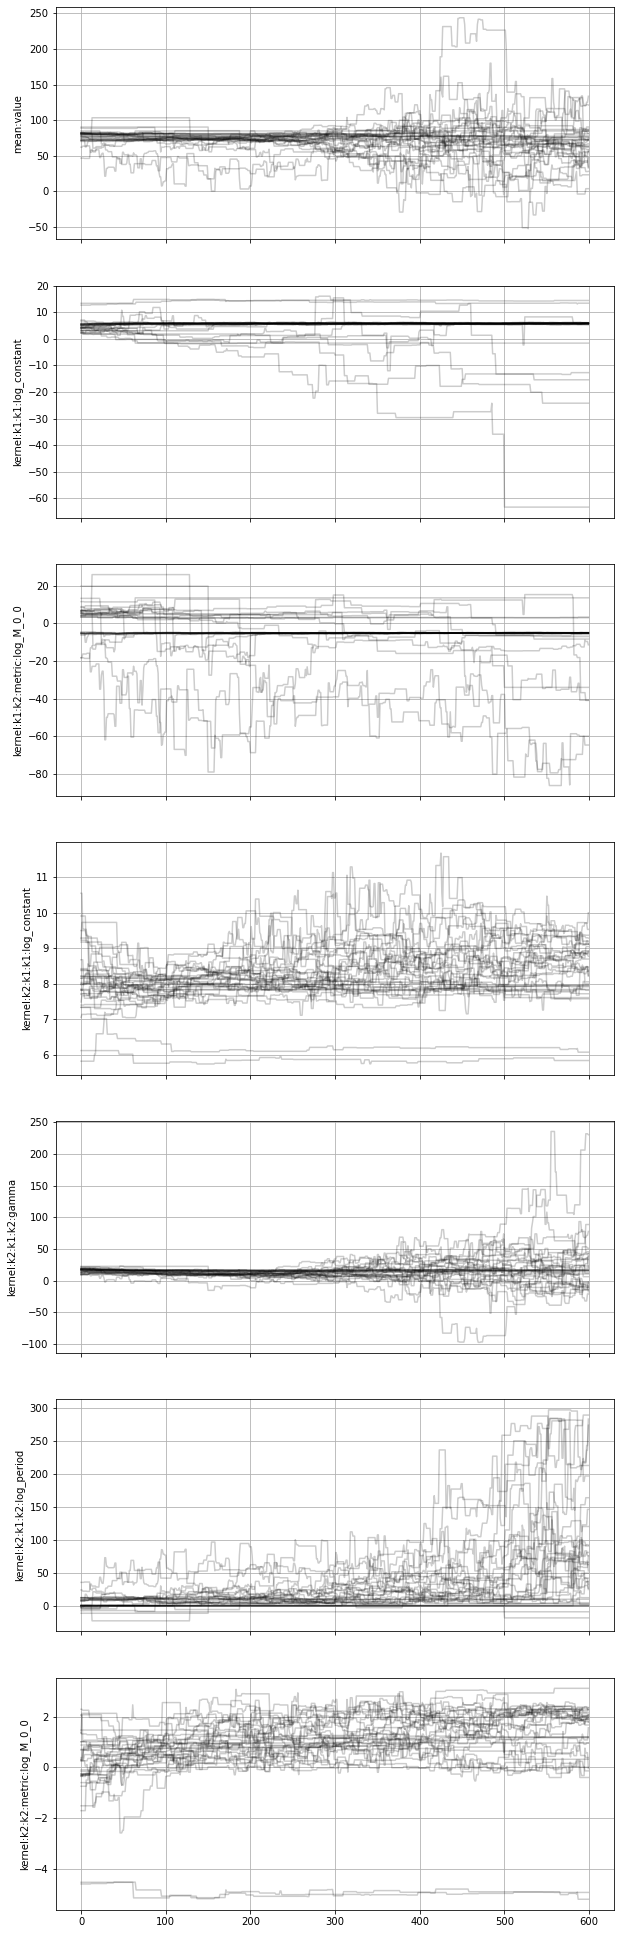

In [488]:
names = gp.get_parameter_names()
plot_chains(sampler, 100, names)

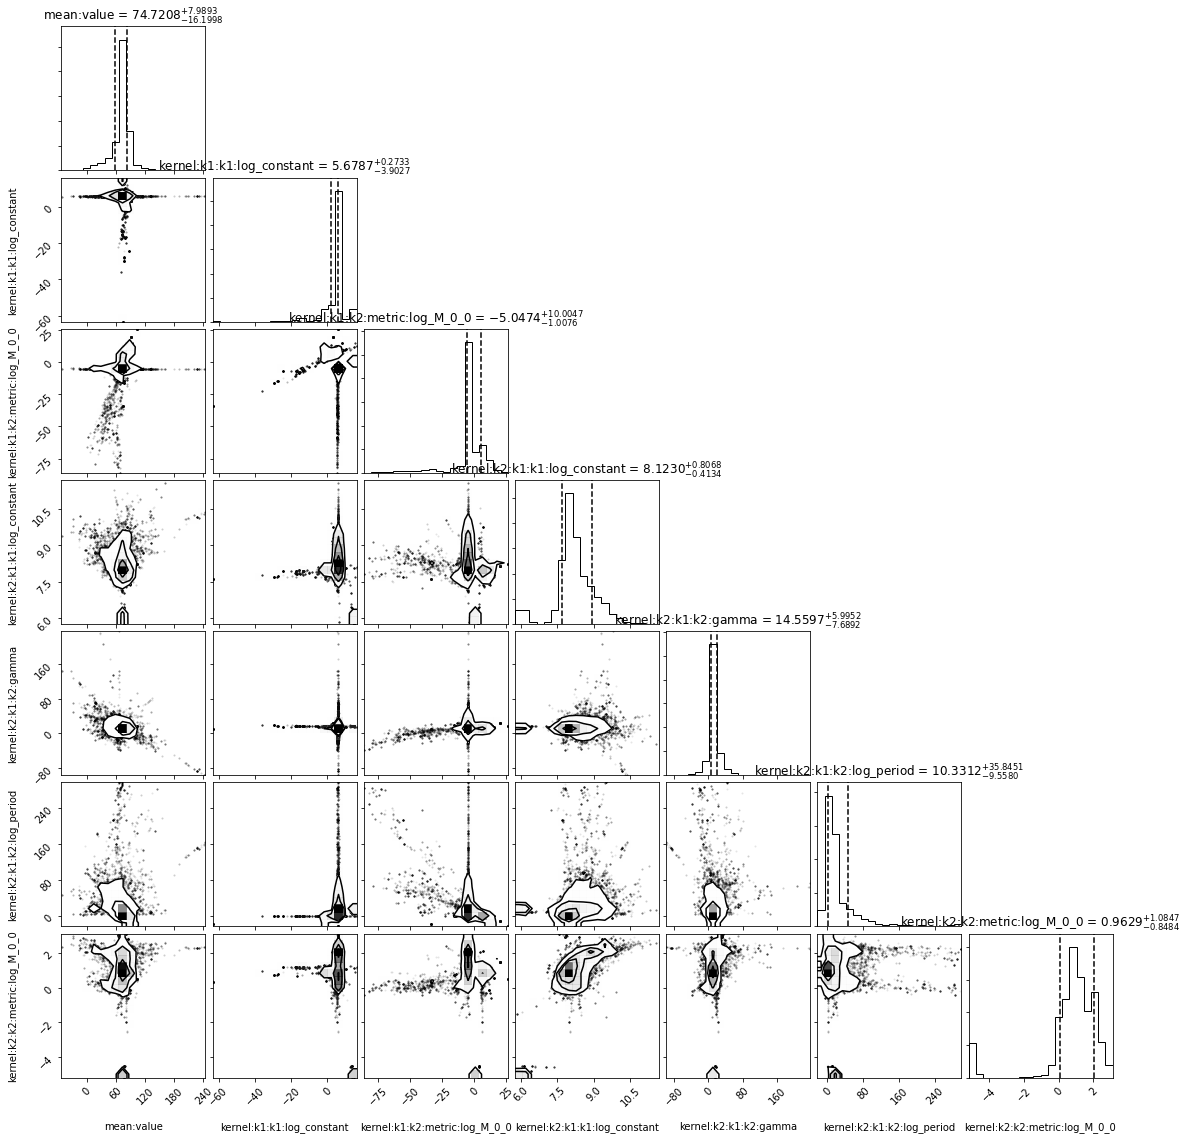

In [489]:
import corner

samples = sampler.get_chain(discard=0, flat=True,)
corner.corner(samples, labels=names, \
              quantiles=(0.16, 0.84), title_fmt='.4f', \
              show_titles=True,);

In [490]:
p_bestfit = np.median(sampler.chain[:,], axis=(0,1))
print('Bestfit parameters:\n', p_bestfit)
print('LnL:', lnprob(p_bestfit))

Bestfit parameters:
 [74.72079587  5.67865727 -5.04740341  8.12295781 14.55971587 10.3312185
  0.96293564]
LnL: -1898.629750946501


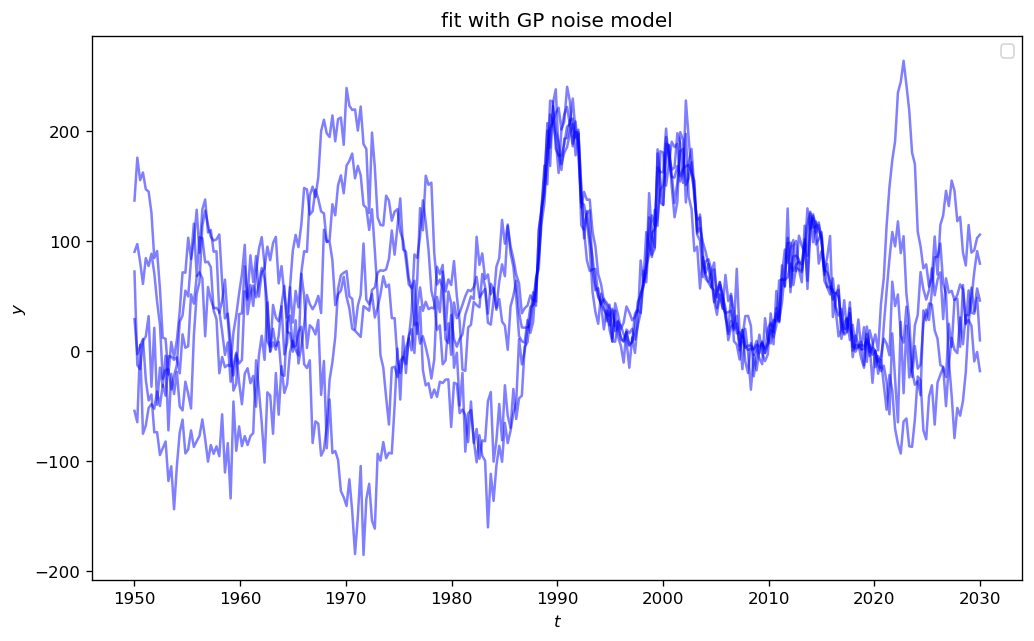

In [494]:
# Plot the data.
fig, ax = plt.subplots(figsize=(10,6), dpi=120)

# plt.errorbar(silso_monthly[:,1], silso_monthly[:,2], yerr=silso_monthly[:,3], fmt=".k", \
#              markersize=2, linestyle='None', alpha=0.08, label='all points')
# plt.errorbar(t, y, yerr=yerr, fmt=".r", markersize=5, linestyle='None', alpha=0.3, \
#              label='condition points')

# The positions where the prediction should be computed.
x = np.linspace(1950, 2030, 300)

# Plot 24 posterior samples.
samples = sampler.flatchain[-40:]
for s in samples[np.random.randint(40, size=5)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu, color="b", alpha=0.5)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")

plt.legend()

plt.title("fit with GP noise model")

plt.show()

### Fourier component

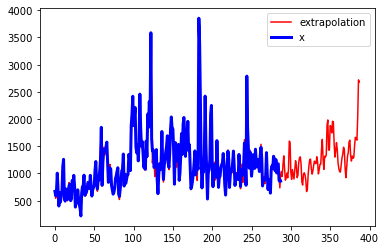

In [499]:
from numpy import fft

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 100                    # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    

x = np.array([669, 592, 664, 1005, 699, 401, 646, 472, 598, 681, 1126, 1260, 562, 491, 714, 530, 521, 687, 776, 802, 499, 536, 871, 801, 965, 768, 381, 497, 458, 699, 549, 427, 358, 219, 635, 756, 775, 969, 598, 630, 649, 722, 835, 812, 724, 966, 778, 584, 697, 737, 777, 1059, 1218, 848, 713, 884, 879, 1056, 1273, 1848, 780, 1206, 1404, 1444, 1412, 1493, 1576, 1178, 836, 1087, 1101, 1082, 775, 698, 620, 651, 731, 906, 958, 1039, 1105, 620, 576, 707, 888, 1052, 1072, 1357, 768, 986, 816, 889, 973, 983, 1351, 1266, 1053, 1879, 2085, 2419, 1880, 2045, 2212, 1491, 1378, 1524, 1231, 1577, 2459, 1848, 1506, 1589, 1386, 1111, 1180, 1075, 1595, 1309, 2092, 1846, 2321, 2036, 3587, 1637, 1416, 1432, 1110, 1135, 1233, 1439, 894, 628, 967, 1176, 1069, 1193, 1771, 1199, 888, 1155, 1254, 1403, 1502, 1692, 1187, 1110, 1382, 1808, 2039, 1810, 1819, 1408, 803, 1568, 1227, 1270, 1268, 1535, 873, 1006, 1328, 1733, 1352, 1906, 2029, 1734, 1314, 1810, 1540, 1958, 1420, 1530, 1126, 721, 771, 874, 997, 1186, 1415, 973, 1146, 1147, 1079, 3854, 3407, 2257, 1200, 734, 1051, 1030, 1370, 2422, 1531, 1062, 530, 1030, 1061, 1249, 2080, 2251, 1190, 756, 1161, 1053, 1063, 932, 1604, 1130, 744, 930, 948, 1107, 1161, 1194, 1366, 1155, 785, 602, 903, 1142, 1410, 1256, 742, 985, 1037, 1067, 1196, 1412, 1127, 779, 911, 989, 946, 888, 1349, 1124, 761, 994, 1068, 971, 1157, 1558, 1223, 782, 2790, 1835, 1444, 1098, 1399, 1255, 950, 1110, 1345, 1224, 1092, 1446, 1210, 1122, 1259, 1181, 1035, 1325, 1481, 1278, 769, 911, 876, 877, 950, 1383, 980, 705, 888, 877, 638, 1065, 1142, 1090, 1316, 1270, 1048, 1256, 1009, 1175, 1176, 870, 856, 860])
n_predict = 100
extrapolation = fourierExtrapolation(x, n_predict)

plt.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
plt.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
plt.legend()
plt.show()